In [175]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install publicsuffix2
%pip install playwright
%pip install dnspython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 313.6/313.6 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [176]:
import json 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from urllib.parse import urlparse
import glob
from collections import Counter, defaultdict
from publicsuffix2 import get_sld
import dns.resolver
import os
import re
plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline

In [134]:
services_path='../services.json'
site_lists='../sites_list.csv'

# ## 1. Data Loading and Setup

In [6]:
class CrawlAnalyzer:
    def __init__(self, services_file=services_path):
        self.load_disconnect_data(services_file)
        
    def load_disconnect_data(self, services_file):
        """Load Disconnect services data"""
        with open(services_file, 'r') as f:
            self.services = json.load(f)
        
        # Build domain to entity mapping
        self.domain_to_entity = {}
        self.domain_categories = defaultdict(set)
        
        for category in self.services['categories']:
            for entity_list in self.services['categories'][category]:
                for entity_name, entity_data in entity_list.items():
                    for url_pattern, domains in entity_data.items():
                        for domain in domains:
                            self.domain_to_entity[domain] = entity_name
                            self.domain_categories[domain].add(category)
    
    def parse_har_file(self, har_path):
        """Parse HAR file and extract relevant data"""
        try:
            with open(har_path, 'r', encoding='utf-8') as f:
                har_data = json.load(f)
        except Exception as e:
            print(f"Error reading {har_path}: {e}")
            return pd.DataFrame()
        
        entries = []
        website_domain = Path(har_path).stem
        
        for entry in har_data['log']['entries']:
            request = entry['request']
            response = entry['response']
            
            # Skip blocked/empty responses as per requirements
            if response['status'] == 0 or response.get('content', {}).get('size', 0) == 0:
                continue
                
            url = request['url']
            parsed_url = urlparse(url)
            domain = get_sld(parsed_url.netloc) if parsed_url.netloc else ''
            
            if not domain:
                continue
                
            # Determine if third-party
            website_sld = get_sld(website_domain)
            is_third_party = domain != website_sld and not domain.endswith('.' + website_sld)
            
            entry_data = {
                'website': website_domain,
                'url': url,
                'domain': domain,
                'is_third_party': is_third_party,
                'status': response['status'],
                'size': response.get('content', {}).get('size', 0)
            }
            
            # Extract headers
            response_headers = {h['name'].lower(): h['value'] for h in response.get('headers', [])}
            request_headers = {h['name'].lower(): h['value'] for h in request.get('headers', [])}
            
            entry_data['response_headers'] = response_headers
            entry_data['request_headers'] = request_headers
            
            # Add entity information
            entry_data['entity'] = self.domain_to_entity.get(domain, 'Unknown')
            entry_data['categories'] = list(self.domain_categories.get(domain, set()))
            
            entries.append(entry_data)
        
        return pd.DataFrame(entries)

# Check available crawl data

In [31]:
analyzer = CrawlAnalyzer(services_path)

crawl_modes = ['accept', 'reject', 'block']
available_data = {}

for mode in crawl_modes:
    har_files = glob.glob(f"../har_logs_{mode}/*.har")
    available_data[mode] = len(har_files)
    print(f"Found {len(har_files)} HAR files for {mode} mode")

Found 40 HAR files for accept mode
Found 0 HAR files for reject mode
Found 0 HAR files for block mode


In [32]:

crawl_data = {}
for mode in crawl_modes:
    print(f"Processing {mode} mode...")
    all_data = []
    har_files = glob.glob(f"../har_logs_{mode}/*.har")
    
    for har_file in har_files:
        df = analyzer.parse_har_file(har_file)
        if not df.empty:
            df['crawl_mode'] = mode
            all_data.append(df)
    
    if all_data:
        crawl_data[mode] = pd.concat(all_data, ignore_index=True)
        print(f"Loaded {len(crawl_data[mode])} requests from {crawl_data[mode]['website'].nunique()} websites")
    else:
        crawl_data[mode] = pd.DataFrame()
        print(f"No data found for {mode} mode")

Processing accept mode...
Loaded 40496 requests from 40 websites
Processing reject mode...
No data found for reject mode
Processing block mode...
No data found for block mode


In [33]:
crawl_data['accept'].head()
crawl_data['reject'].head()
crawl_data['block'].head()

""


In [34]:
for mode, data in crawl_data.items():
     if not data.empty:
         print(f"\n{mode.upper()} MODE:")
         print(f"Total requests: {len(data):,}")
         print(f"Websites crawled: {data['website'].nunique()}")
         print(f"Third-party requests: {data['is_third_party'].sum():,} ({data['is_third_party'].mean():.1%})")
         print(f"Unique domains: {data['domain'].nunique()}")
         print(f"Unique entities: {data[data['entity'] != 'Unknown']['entity'].nunique()}")


ACCEPT MODE:
Total requests: 40,496
Websites crawled: 40
Third-party requests: 35,717 (88.2%)
Unique domains: 685
Unique entities: 247


#### 1: Boxplot Comparison

In [35]:
def calculate_basic_metrics(df):
    """Calculate metrics for Q1 and Q2"""
    if df.empty:
        return pd.DataFrame()
        
    metrics = df.groupby('website').agg({
        'url': 'count',  # Total requests
        'is_third_party': 'sum',  # Third-party requests
    }).rename(columns={
        'url': 'total_requests',
        'is_third_party': 'third_party_requests',
    })
    
    # Distinct third-party domains
    third_party_domains = df[df['is_third_party']].groupby('website')['domain'].nunique()
    metrics['distinct_third_party_domains'] = third_party_domains
    
    # Distinct entities
    distinct_entities = df[df['is_third_party']].groupby('website')['entity'].apply(
        lambda x: x[x != 'Unknown'].nunique()
    )
    metrics['distinct_entities'] = distinct_entities
    
    return metrics.fillna(0)

In [36]:
print("Calculating metrics for each crawl mode...")
metrics = {}
for mode in crawl_modes:
    if not crawl_data[mode].empty:
        metrics[mode] = calculate_basic_metrics(crawl_data[mode])
        print(f"{mode}: {len(metrics[mode])} websites")


Calculating metrics for each crawl mode...
accept: 40 websites


# Create boxplots for Question 1

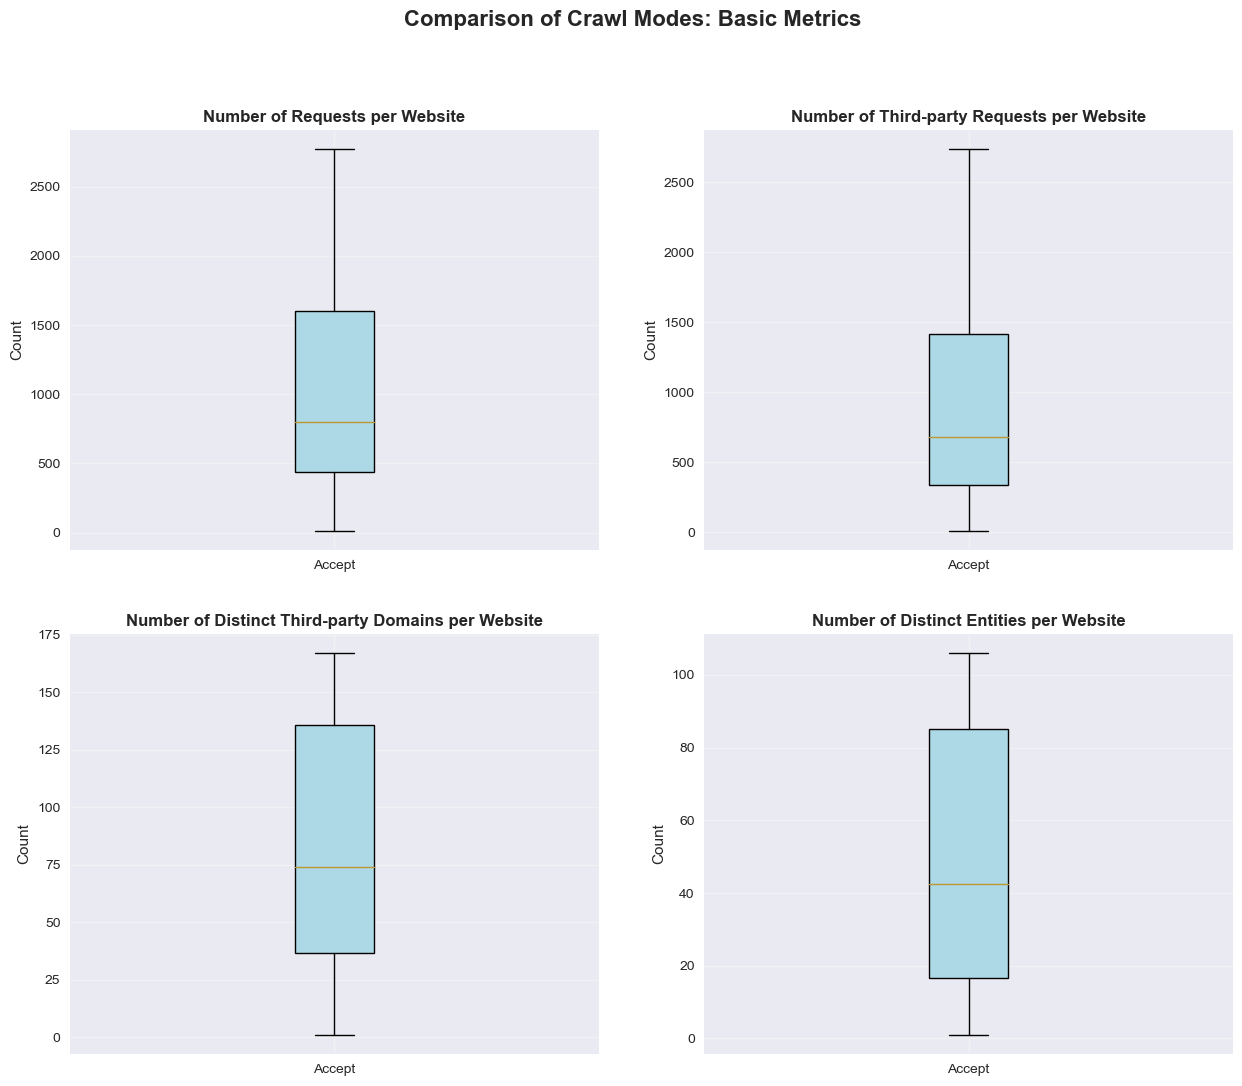

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparison of Crawl Modes: Basic Metrics', fontsize=16, fontweight='bold')

metric_configs = [
    ('total_requests', 'Number of Requests per Website'),
    ('third_party_requests', 'Number of Third-party Requests per Website'),
    ('distinct_third_party_domains', 'Number of Distinct Third-party Domains per Website'),
    ('distinct_entities', 'Number of Distinct Entities per Website')
]

for idx, (metric, title) in enumerate(metric_configs):
    ax = axes[idx//2, idx%2]
    
    plot_data = []
    labels = []
    for mode in crawl_modes:
        if mode in metrics and not metrics[mode].empty and metric in metrics[mode].columns:
            data = metrics[mode][metric].dropna()
            if len(data) > 0:
                plot_data.append(data)
                labels.append(mode.capitalize())
    
    if plot_data:
        boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True)
        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_title(title, fontweight='bold')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
 
plt.show()

#### 2:

In [38]:
comparison_data = []
metrics_list = ['total_requests', 'third_party_requests', 
               'distinct_third_party_domains', 'distinct_entities']

for metric in metrics_list:
    row = {'Metric': metric.replace('_', ' ').title()}
    
    for mode in crawl_modes:
        if mode in metrics and not metrics[mode].empty and metric in metrics[mode].columns:
            data = metrics[mode][metric].dropna()
            if len(data) > 0:
                row[f'{mode}_min'] = data.min()
                row[f'{mode}_median'] = data.median()
                row[f'{mode}_max'] = data.max()
                row[f'{mode}_mean'] = data.mean()
            else:
                row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
        else:
            row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("Comparison Table:")
display(comparison_df.round(1))

Comparison Table:


,Metric,accept_min,accept_median,accept_max,accept_mean,reject_min,reject_median,reject_max,reject_mean,block_min,block_median,block_max,block_mean
0,Total Requests,14,800.0,2772,1012.4,0,0,0,0,0,0,0,0
1,Third Party Requests,11,681.0,2738,892.9,0,0,0,0,0,0,0,0
2,Distinct Third Party Domains,1,74.0,167,81.2,0,0,0,0,0,0,0,0
3,Distinct Entities,1,42.5,106,49.4,0,0,0,0,0,0,0,0


#### 3

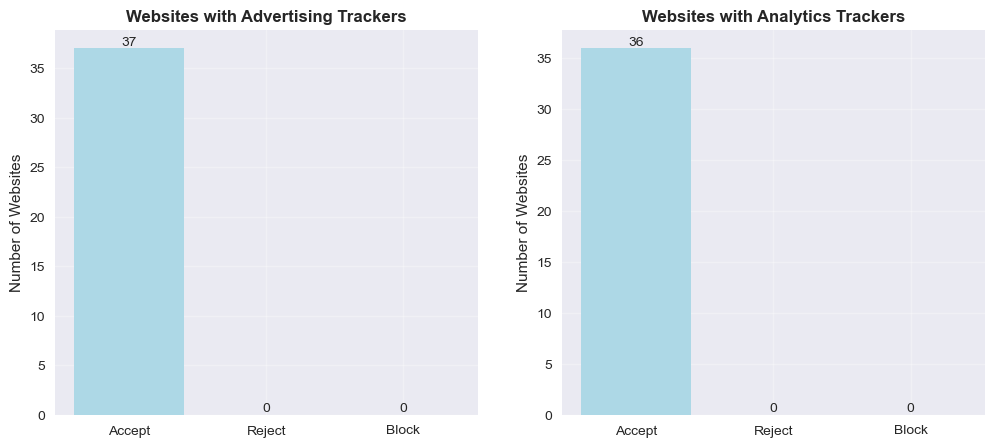

In [39]:
def analyze_tracking_categories(df, mode_name):
    """Analyze websites with at least one request to tracking categories"""
    if df.empty:
        return {'Advertising': 0, 'Analytics': 0}
    
    websites_with_ads = set()
    websites_with_analytics = set()
    
    for website, website_data in df.groupby('website'):
        # Get all unique categories requested by this website
        all_categories = set()
        for _, row in website_data.iterrows():
            all_categories.update(row.get('categories', []))
        
        # Check if website contacted tracking domains
        if 'Advertising' in all_categories:
            websites_with_ads.add(website)
        if 'Analytics' in all_categories:
            websites_with_analytics.add(website)
    
    return {
        'Advertising': len(websites_with_ads),
        'Analytics': len(websites_with_analytics)
    }

tracking_results = {}
for mode in crawl_modes:
    if not crawl_data[mode].empty:
        tracking_results[mode] = analyze_tracking_categories(crawl_data[mode], mode)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ad_data = [tracking_results.get(mode, {}).get('Advertising', 0) for mode in crawl_modes]
bars1 = ax1.bar([m.capitalize() for m in crawl_modes], ad_data, color=['lightblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Websites with Advertising Trackers', fontweight='bold')
ax1.set_ylabel('Number of Websites')
ax1.grid(True, alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

analytics_data = [tracking_results.get(mode, {}).get('Analytics', 0) for mode in crawl_modes]
bars2 = ax2.bar([m.capitalize() for m in crawl_modes], analytics_data, color=['lightblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Websites with Analytics Trackers', fontweight='bold')
ax2.set_ylabel('Number of Websites')
ax2.grid(True, alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

#### 4: US vs European News Sites Comparison

In [40]:
def load_country_mappings(site_list_path=site_lists):
    
    site_list_df = pd.read_csv(site_list_path)
    domain_to_country = dict(zip(site_list_df['domain'], site_list_df['country']))
    return domain_to_country
    
def get_country_code(website, domain_to_country):
    website_lower = website.lower()
    
   
    if domain_to_country and website_lower in domain_to_country:
        return domain_to_country[website_lower]
    
    # # Second try: Partial match (e.g., "www.nos.nl" matches "nos.nl")
    # if domain_to_country:
    #     for domain, country in domain_to_country.items():
    #         if domain in website_lower:
    #             return country
    

def analyze_us_vs_european_with_site_list(accept_data, site_list_path=site_lists):
    if accept_data.empty:
        return pd.DataFrame(), pd.DataFrame()
    
    domain_to_country = load_country_mappings(site_list_path)
    
    us_websites = []
    european_websites = []
    other_websites = []
    
    for website in accept_data['website'].unique():
        country = get_country_code(website, domain_to_country)
        
        if country == 'us':
            us_websites.append(website)
        elif country in ['nl', 'de', 'fr', 'it', 'uk', 'es', 'be']:  # European countries
            european_websites.append(website)
        else:
            other_websites.append(website)
    
    us_data = accept_data[accept_data['website'].isin(us_websites)]
    european_data = accept_data[accept_data['website'].isin(european_websites)]
    
    print(f"US sites (site-list classification): {len(us_websites)} websites")
    print(f"European sites (site-list classification): {len(european_websites)} websites")
    print(f"Other sites: {len(other_websites)} websites")
    
    us_metrics = calculate_basic_metrics(us_data)
    european_metrics = calculate_basic_metrics(european_data)
    
    return us_metrics, european_metrics, us_data, european_data, us_websites, european_websites

if 'accept' in crawl_data and not crawl_data['accept'].empty:
    (us_metrics, european_metrics, us_data, european_data, 
     us_websites, european_websites) = analyze_us_vs_european_with_site_list(crawl_data['accept'])
    
    comparison_data = []
    metrics_list = ['total_requests', 'third_party_requests', 
                   'distinct_third_party_domains', 'distinct_entities']
    
    for metric in metrics_list:
        row = {'Metric': metric.replace('_', ' ').title()}
        
        if not us_metrics.empty and metric in us_metrics.columns:
            us_data_metric = us_metrics[metric].dropna()
            if len(us_data_metric) > 0:
                row['US_Min'] = us_data_metric.min()
                row['US_Median'] = us_data_metric.median()
                row['US_Max'] = us_data_metric.max()
                row['US_Mean'] = us_data_metric.mean()
            else:
                row.update({'US_Min': 0, 'US_Median': 0, 'US_Max': 0, 'US_Mean': 0})
        else:
            row.update({'US_Min': 0, 'US_Median': 0, 'US_Max': 0, 'US_Mean': 0})
        
        # European metrics
        if not european_metrics.empty and metric in european_metrics.columns:
            eu_data_metric = european_metrics[metric].dropna()
            if len(eu_data_metric) > 0:
                row['European_Min'] = eu_data_metric.min()
                row['European_Median'] = eu_data_metric.median()
                row['European_Max'] = eu_data_metric.max()
                row['European_Mean'] = eu_data_metric.mean()
            else:
                row.update({'European_Min': 0, 'European_Median': 0, 'European_Max': 0, 'European_Mean': 0})
        else:
            row.update({'European_Min': 0, 'European_Median': 0, 'European_Max': 0, 'European_Mean': 0})
        
        comparison_data.append(row)
    
    us_eu_comparison_df = pd.DataFrame(comparison_data)
    display(us_eu_comparison_df.round(1))

US sites (site-list classification): 20 websites
European sites (site-list classification): 20 websites
Other sites: 0 websites


,Metric,US_Min,US_Median,US_Max,US_Mean,European_Min,European_Median,European_Max,European_Mean
0,Total Requests,14,772.0,2772,1001.3,152,800.0,2532,1023.5
1,Third Party Requests,12,623.5,2738,867.6,11,681.0,2496,918.3
2,Distinct Third Party Domains,1,67.0,162,75.1,8,90.0,167,87.2
3,Distinct Entities,1,37.5,103,44.7,2,55.5,106,54.2


In [41]:
comparison_data = []
metrics_list = ['total_requests', 'third_party_requests', 
               'distinct_third_party_domains', 'distinct_entities']

for metric in metrics_list:
    row = {'Metric': metric.replace('_', ' ').title()}
    
    for mode in crawl_modes:
        if mode in metrics and not metrics[mode].empty and metric in metrics[mode].columns:
            data = metrics[mode][metric].dropna()
            if len(data) > 0:
                row[f'{mode}_min'] = data.min()
                row[f'{mode}_median'] = data.median()
                row[f'{mode}_max'] = data.max()
                row[f'{mode}_mean'] = data.mean()
            else:
                row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
        else:
            row.update({f'{mode}_min': 0, f'{mode}_median': 0, f'{mode}_max': 0, f'{mode}_mean': 0})
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("Comparison Table:")
display(comparison_df.round(1))


Comparison Table:


,Metric,accept_min,accept_median,accept_max,accept_mean,reject_min,reject_median,reject_max,reject_mean,block_min,block_median,block_max,block_mean
0,Total Requests,14,800.0,2772,1012.4,0,0,0,0,0,0,0,0
1,Third Party Requests,11,681.0,2738,892.9,0,0,0,0,0,0,0,0
2,Distinct Third Party Domains,1,74.0,167,81.2,0,0,0,0,0,0,0,0
3,Distinct Entities,1,42.5,106,49.4,0,0,0,0,0,0,0,0


#### 5: Advertising and Analytics Tracking


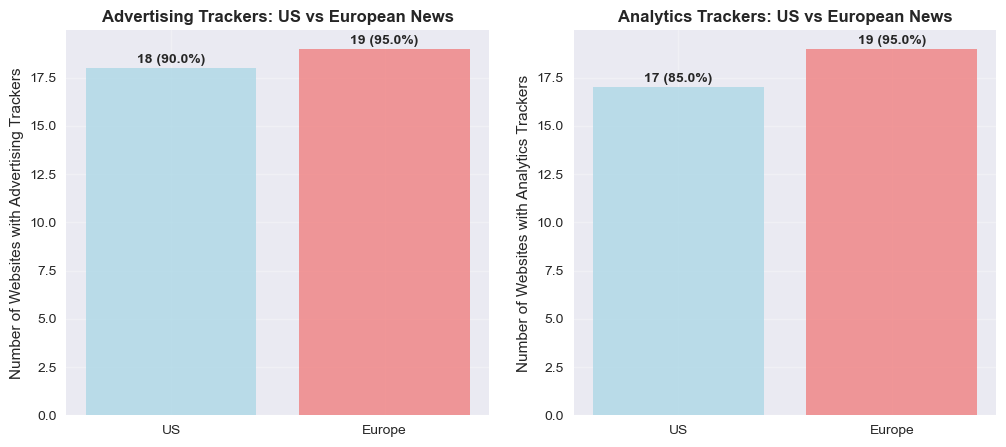

In [42]:
def analyze_region_tracking_categories(us_data, european_data):
    
    # Analyze tracking categories for both regions
    us_tracking = analyze_tracking_categories(us_data, 'US News')
    eu_tracking = analyze_tracking_categories(european_data, 'European News')
    
   
    region_results = {
        'US': {
            'Advertising': us_tracking['Advertising'],
            'Analytics': us_tracking['Analytics'],
            'total_websites': us_data['website'].nunique()
        },
        'Europe': {
            'Advertising': eu_tracking['Advertising'],
            'Analytics': eu_tracking['Analytics'],
            'total_websites': european_data['website'].nunique()
        }
    }
    
    return region_results

def create_region_tracking_plot(region_results):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    regions = ['US', 'Europe']
    colors = ['lightblue', 'lightcoral']
    
   
    ad_data = [region_results[region]['Advertising'] for region in regions]
    analytics_data = [region_results[region]['Analytics'] for region in regions]
    total_websites = [region_results[region]['total_websites'] for region in regions]
    
   
    ad_percentages = [ (ad_data[i] / total_websites[i]) * 100 if total_websites[i] > 0 else 0 
                      for i in range(len(regions)) ]
    analytics_percentages = [ (analytics_data[i] / total_websites[i]) * 100 if total_websites[i] > 0 else 0 
                             for i in range(len(regions)) ]
    
    # Plot 5a: Advertising comparison
    bars1 = ax1.bar(regions, ad_data, color=colors, alpha=0.8)
    ax1.set_title('Advertising Trackers: US vs European News', fontweight='bold')
    ax1.set_ylabel('Number of Websites with Advertising Trackers')
    ax1.grid(True, alpha=0.3)
    
    
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)} ({ad_percentages[i]:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 5b: Analytics comparison  
    bars2 = ax2.bar(regions, analytics_data, color=colors, alpha=0.8)
    ax2.set_title('Analytics Trackers: US vs European News', fontweight='bold')
    ax2.set_ylabel('Number of Websites with Analytics Trackers')
    ax2.grid(True, alpha=0.3)
    
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)} ({analytics_percentages[i]:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    
   
region_tracking_results = analyze_region_tracking_categories(us_data, european_data)
create_region_tracking_plot(region_tracking_results)
    


####  6: Top Third-party Domains

In [43]:


def cookie_analysis(accept_data):

    def parse_cookie_header(header_value):
    
        if not header_value:
            return []
        
        cookie_names = []
        
        try:
            # Handle list of headers
            if isinstance(header_value, list):
                for item in header_value:
                    cookie_names.extend(parse_single_cookie_header(item))
            else:
                cookie_names.extend(parse_single_cookie_header(header_value))
                
        except Exception as e:
            print(f"Cookie parsing error: {e}")
            
        return [name for name in cookie_names if name and len(name) > 1]
    
    def parse_single_cookie_header(header):
    
        names = []
        
        clean_header = re.split(r';\s*(?=\w+=)', header)
        
        for cookie_part in clean_header:
            if '=' in cookie_part:
                name = cookie_part.split('=', 1)[0].strip()
            
                if (name and 
                    not name.lower() in ['path', 'domain', 'expires', 'max-age', 'secure', 'httponly', 'samesite'] and
                    not name.startswith('__') and  # Often internal flags
                    len(name) > 1):
                    names.append(name)
        
        return names
    
    js_cookies = []
    website_cookie_flow = {}
    
    for website, website_data in accept_data.groupby('website'):
        server_cookies = set()
        request_cookies = {}
        
        # server-set cookies
        for _, row in website_data.iterrows():
            resp_headers = row.get('response_headers', {})
            if 'set-cookie' in resp_headers:
                cookies = parse_cookie_header(resp_headers['set-cookie'])
                server_cookies.update(cookies)
        
        # find client-side cookies
        for _, row in website_data.iterrows():
            req_headers = row.get('request_headers', {})
            domain = row['domain']
            
            if 'cookie' in req_headers:
                cookies = parse_cookie_header(req_headers['cookie'])
                for cookie_name in cookies:
                    if cookie_name not in server_cookies:
                        js_cookies.append({
                            'cookie_name': cookie_name,
                            'website': website,
                            'cookie_domain': domain
                        })
    
    return pd.DataFrame(js_cookies)


if 'accept' in crawl_data and not crawl_data['accept'].empty:
    results = cookie_analysis(crawl_data['accept'])
    
    # Clean and display results
    results = results.drop_duplicates()
    results = results.sort_values(['website', 'cookie_name'])
    

    display(results.head(50)) 
    


,cookie_name,website,cookie_domain
232,CMID,ad.nl,casalemedia.com
233,CMPS,ad.nl,casalemedia.com
28,IDE,ad.nl,doubleclick.net
300,TDID,ad.nl,adsrvr.org
740,VP,ad.nl,contextweb.com
0,XANDR_PANID,ad.nl,adnxs.com
17,_ga,ad.nl,ad.nl
18,_ga_DN0P5D59BT,ad.nl,ad.nl
21,_gcl_au,ad.nl,ad.nl
19,_pubcid,ad.nl,ad.nl


#####  7:  most prevalent third-party domains

In [44]:

for mode in crawl_modes:
    if mode in crawl_data and not crawl_data[mode].empty:
        # Create prevalence table
        prevalence_table = (crawl_data[mode][crawl_data[mode]['is_third_party']]
                           .groupby('domain')
                           .agg({'website': 'nunique', 'categories': 'first'})
                           .rename(columns={'website': 'Number of distinct websites'})
                           .sort_values('Number of distinct websites', ascending=False)
                           .head(10)
                           .reset_index()
                           .rename(columns={'domain': 'Third-party domain'}))
        
        # Format categories
        prevalence_table['Disconnect categories'] = prevalence_table['categories'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) and x else 'NA'
        )
        prevalence_table = prevalence_table.drop('categories', axis=1)
        
        print(f"\n{mode.upper()} MODE:")
        display(prevalence_table)
        # prevalence_table.to_csv(f'q8_{mode}_prevalence.csv', index=False)


ACCEPT MODE:


,Third-party domain,Number of distinct websites,Disconnect categories
0,doubleclick.net,35,"Advertising, Email, FingerprintingGeneral"
1,google.com,34,Content
2,adtrafficquality.google,33,Advertising
3,googlesyndication.com,33,"Advertising, FingerprintingGeneral"
4,amazon-adsystem.com,32,Advertising
5,fonts.googleapis.com,32,NA
6,adsrvr.org,31,"Advertising, FingerprintingGeneral"
7,adnxs.com,31,Advertising
8,gstatic.com,30,Content
9,demdex.net,29,"Advertising, Email, FingerprintingGeneral"


##### 8: highest number of distinct third-party domains

In [45]:
def websites_analysis(crawl_data, crawl_modes, top_n=10):
    
    domain_to_country = load_country_mappings(site_lists)
    
    all_results = {}
    
    for mode in crawl_modes:
        if mode in crawl_data and not crawl_data[mode].empty:
            website_table = (crawl_data[mode][crawl_data[mode]['is_third_party']]
                           .groupby('website')
                           .agg({'domain': 'nunique'})
                           .rename(columns={'domain': 'Number of distinct third-party domains'})
                           .sort_values('Number of distinct third-party domains', ascending=False)
                           .head(top_n)
                           .reset_index()
                           .rename(columns={'website': 'Website'}))
            
            website_table['Country code'] = website_table['Website'].apply(
                lambda x: get_country_code(x, domain_to_country)
            )
            
            website_table = website_table[['Website', 'Country code', 'Number of distinct third-party domains']]
            
            all_results[mode] = website_table
            
            display(website_table)
           
    
    return all_results


results = websites_analysis(crawl_data, crawl_modes, top_n=10)

,Website,Country code,Number of distinct third-party domains
0,nltimes.nl,nl,167
1,huffpost.com,us,162
2,apnews.com,us,159
3,gazzetta.it,it,149
4,libero.it,it,148
5,corriere.it,it,148
6,newsweek.com,us,147
7,dailymail.co.uk,uk,142
8,the-sun.com,uk,139
9,buzzfeed.com,us,137


#### 9: highest number of distinct server IP addresses per website

In [46]:
def server_ip_analysis(crawl_data, crawl_modes, top_n=10):

    
    domain_to_country = load_country_mappings(site_lists)
    
    all_data = []
    
    for mode in crawl_modes:
        if mode in crawl_data and not crawl_data[mode].empty:
            df = crawl_data[mode]
            
            # Count distinct domains per website (as proxy for server IPs)
            stats = (df.groupby('website')
                    .agg({'domain': 'nunique'})
                    .reset_index()
                    .rename(columns={'domain': 'ip_count'}))
            
            stats['Crawl type'] = mode.capitalize()
            

            stats['Country code'] = stats['website'].apply(
                lambda x: get_country_code(x, domain_to_country)
            )
            
            all_data.append(stats)
    
    if not all_data:
        return pd.DataFrame()
    
    
    combined = pd.concat(all_data, ignore_index=True)
    top_visits = (combined.sort_values('ip_count', ascending=False)
                  .head(top_n)
                  .reset_index(drop=True))
    
    # Create final table
    result = top_visits[['website', 'Crawl type', 'Country code']].copy()
    result['Number of distinct server IPs ↓'] = top_visits['ip_count']
    result = result.rename(columns={'website': 'Website'})
   
    return result

server_ip_analysis(crawl_data, crawl_modes)

,Website,Crawl type,Country code,Number of distinct server IPs ↓
0,nltimes.nl,Accept,nl,168
1,huffpost.com,Accept,us,163
2,apnews.com,Accept,us,160
3,gazzetta.it,Accept,it,150
4,libero.it,Accept,it,149
5,corriere.it,Accept,it,149
6,newsweek.com,Accept,us,148
7,dailymail.co.uk,Accept,uk,143
8,the-sun.com,Accept,uk,140
9,buzzfeed.com,Accept,us,138


##### 10:  Permissions-Policy 

In [47]:
def permissions_analysis(crawl_data, crawl_modes):
    
    def parse_policy(header_value):
       
        if not header_value:
            return []
        
        disabled = []
        try:
            if isinstance(header_value, list):
                header_value = ' '.join(header_value)
            
            patterns = [
                r'(\w+)=\(\)',           
                r"(\w+)='none'",        
                r'(\w+)=""',            
            ]
            
            for pattern in patterns:
                matches = re.findall(pattern, header_value)
                disabled.extend(matches)
                
        except Exception as e:
            pass  
            
        return disabled
    
    all_results = {}
    
    for mode in crawl_modes:
        if mode not in crawl_data or crawl_data[mode].empty:
            continue
            
        print(f"Processing {mode} mode...")
        df = crawl_data[mode]
        
        permission_counts = {}
        websites_with_policy = 0
        
        for website, website_data in df.groupby('website'):
            website_disabled = set()
            
            for _, row in website_data.iterrows():
                headers = row.get('response_headers', {})
                
                # Check for policy headers
                for header_name, header_value in headers.items():
                    if 'permissions-policy' in header_name.lower() or 'feature-policy' in header_name.lower():
                        disabled_perms = parse_policy(header_value)
                        website_disabled.update(disabled_perms)
            
            if website_disabled:
                websites_with_policy += 1
                for perm in website_disabled:
                    permission_counts[perm] = permission_counts.get(perm, 0) + 1
        
        all_results[mode] = {
            'permission_counts': permission_counts,
            'websites_with_policy': websites_with_policy,
            'total_websites': df['website'].nunique()
        }
    
    return all_results

def create_table(results, crawl_modes, top_n=5):
    
    all_perms = set()
    for mode in crawl_modes:
        if mode in results:
            all_perms.update(results[mode]['permission_counts'].keys())
    
    perm_totals = {}
    for perm in all_perms:
        total = 0
        for mode in crawl_modes:
            if mode in results:
                total += results[mode]['permission_counts'].get(perm, 0)
        perm_totals[perm] = total
    
    top_perms = sorted(perm_totals.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    table_data = []
    for perm, _ in top_perms:
        row = {'Permission': perm}
        for mode in crawl_modes:
            count = results.get(mode, {}).get('permission_counts', {}).get(perm, 0)
            row[mode.capitalize()] = count
        table_data.append(row)
    
    return pd.DataFrame(table_data)


simple_results = permissions_analysis(crawl_data, crawl_modes)

if simple_results:
    table = create_table(simple_results, crawl_modes)
    
    print("\nRESULTS:")
    print(f"{'Permission':<20} {'Accept':<8} {'Reject':<8} {'Block':<8}")
    print("-" * 50)
    
    for _, row in table.iterrows():
        print(f"{row['Permission']:<20} {row['Accept']:<8} {row['Reject']:<8} {row['Block']:<8}")
    


Processing accept mode...

RESULTS:
Permission           Accept   Reject   Block   
--------------------------------------------------
geolocation          20       0        0       
microphone           20       0        0       
camera               20       0        0       
cohort               18       0        0       
read                 17       0        0       


#### 11: Referrer-Policy 

In [50]:
def quick_referrer_analysis(crawl_data, crawl_modes):
    """Quick analysis focusing on the main non-default policies"""
    
    target_policies = ['no-referrer', 'same-origin', 'unsafe-url', 'strict-origin']
    
    results = {mode: {p: 0 for p in target_policies} for mode in crawl_modes}
    
    for mode in crawl_modes:
        if mode not in crawl_data or crawl_data[mode].empty:
            continue
            
        df = crawl_data[mode]
        
        for website, website_data in df.groupby('website'):
            found_policies = set()
            
            for _, row in website_data.iterrows():
                headers = row.get('response_headers', {})
                
                for header_name, header_value in headers.items():
                    if 'referrer-policy' in header_name.lower():
                        policy = str(header_value).strip().lower()
                        if policy in target_policies:
                            found_policies.add(policy)
            
            for policy in found_policies:
                results[mode][policy] += 1
    
    # Display results
   
    print(f"{'Referrer Policy':<20} {'Crawl-Accept':<15} {'Crawl-Reject':<15} {'Crawl-Block':<15}")
    print("-" * 70)
    
    for policy in target_policies:
        accept = results.get('accept', {}).get(policy, 0)
        reject = results.get('reject', {}).get(policy, 0)
        block = results.get('block', {}).get(policy, 0)
        print(f"{policy:<20} {accept:<15} {reject:<15} {block:<15}")
    
    return results

quick_results = quick_referrer_analysis(crawl_data, crawl_modes)

Referrer Policy      Crawl-Accept    Crawl-Reject    Crawl-Block    
----------------------------------------------------------------------
no-referrer          8               0               0              
same-origin          7               0               0              
unsafe-url           3               0               0              
strict-origin        1               0               0              


In [217]:
def analyze_accept_ch_headers(crawl_data, crawl_modes):
    """Analysis of Accept-CH headers by making a list of the 3 high-entropy client hints per mode"""
    
    low_entropy_chs = {"save-data", "sec-ch-ua", "sec-ch-ua-mobile", "sec-ch-ua-platform"}
    
    results = {}
    
    for mode in crawl_modes:
        if mode not in crawl_data or crawl_data[mode].empty:
            results[mode] = [("", 0),("", 0),("", 0)]
            continue
            
        df = crawl_data[mode]
        ch_website_sets = {}
        
        for website, website_data in df.groupby('website'):
            found_chs = set()
            
            for _, row in website_data.iterrows():
                headers = row.get('response_headers', {})
                
                for header_name, header_value in headers.items():
                    if 'accept-ch' in header_name.lower():
                        for header_value in header_value.split(','):
                            if header_value.strip().lower() not in low_entropy_chs:
                                found_chs.add(header_value.strip().lower())
                        
            for ch in found_chs:
                if ch not in ch_website_sets:
                    ch_website_sets[ch] = set()
                ch_website_sets[ch].add(website)  # add this website to the set

        # Convert sets to counts
        ch_counts = {ch: len(sites) for ch, sites in ch_website_sets.items()}
        
        # Sort by number of websites, descending
        top_chs = sorted(ch_counts.items(), key=lambda x: x[1], reverse=True)[:3]
        
        results[mode] = top_chs
        
    # Display results
    print(f"{'Crawl-Accept':<35} {'Crawl-Reject':<35} {'Crawl-Block':<35}")
    print("-" * 105)
    
    for i in range(len(top_chs)):
        accept = f"{results['accept'][i][0]}: {results['accept'][i][1]}" 
        reject = f"{results['reject'][i][0]}: {results['reject'][i][1]}" 
        block  = f"{results['block'][i][0]}: {results['block'][i][1]}"
        print(f"{accept:<35} {reject:<35} {block:<35}")
    
    return results
          
accept_ch_headers_results = analyze_accept_ch_headers(crawl_data, crawl_modes)

Crawl-Accept                        Crawl-Reject                        Crawl-Block                        
---------------------------------------------------------------------------------------------------------
sec-ch-ua-model: 34                 : 0                                 : 0                                
sec-ch-ua-platform-version: 33      : 0                                 : 0                                
sec-ch-ua-arch: 33                  : 0                                 : 0                                


In [218]:
def analyze_cross_entity_redirections(crawl_data, crawl_modes, analyzer):
    """Analysis of cross-entity HTTP redirects per crawl mode"""
    
    results = {mode: set() for mode in crawl_modes} #(source_domian, source_entity, target_domain, target_entity, website)

    for mode in crawl_modes:
        if mode not in crawl_data or crawl_data[mode].empty:
            results[mode] = [] 
            continue

        df = crawl_data[mode]
        
        for website, website_data in df.groupby('website'):
            for _, row in website_data.iterrows():
                status = row.get('status', 0)
                if status not in {300, 301, 302, 303, 304, 307, 308}:
                    continue

                headers = row.get('response_headers', {})
                location = headers.get('location')
                if not location:
                    continue

                # source
                source_domain = row.get('domain', '')
                source_entity = analyzer.domain_to_entity.get(source_domain)

                # target
                target_domain = get_sld(urlparse(location).netloc)
                target_entity = analyzer.domain_to_entity.get(target_domain)

                # include only if both domains exist in Disconnect entity list and differ
                if source_entity and target_entity and source_entity != target_entity:
                    results[mode].add((
                        source_domain,
                        source_entity,
                        target_domain,
                        target_entity,
                        website
                    ))
                
    # Display results
    for mode in crawl_modes:
        print(mode)
        print()
        print(f"{'Source Domain':<25} {'Source Entity':<25} {'Target Domain':<25} {'Target Entity':<25} {'Website':<25}")
        print("-" * 125)
        for source_domain, source_entity, target_domain, target_entity, website in sorted(results[mode], key=lambda x: x[0].lower()):
            print(f"{source_domain:<25} "
                  f"{source_entity:<25} "
                  f"{target_domain:<25} "
                  f"{target_entity:<25} "
                  f"{website:<25}")
        print()

    return results 

    
cross_entity_redirections_results = analyze_cross_entity_redirections(crawl_data, crawl_modes, analyzer)

accept

Source Domain             Source Entity             Target Domain             Target Entity             Website                  
-----------------------------------------------------------------------------------------------------------------------------
1rx.io                    Nexxen                    adsrvr.org                The Trade Desk            theguardian.com          
1rx.io                    Nexxen                    adsrvr.org                The Trade Desk            buzzfeed.com             
1rx.io                    Nexxen                    adsrvr.org                The Trade Desk            huffpost.com             
1rx.io                    Nexxen                    adsrvr.org                The Trade Desk            lefigaro.fr              
1rx.io                    Nexxen                    adsrvr.org                The Trade Desk            nltimes.nl               
1rx.io                    Nexxen                    onetag-sys.com            OneTag  

In [209]:
def analyze_first_party_cnames(crawl_data, crawl_modes, analyzer):
    """
    For each crawl mode, check first-party requests for CNAMEs that go to Disconnect-listed domains.
    """

    results = {mode: set() for mode in crawl_modes}

    for mode in crawl_modes:
        if mode not in crawl_data or crawl_data[mode].empty:
            continue

        df = crawl_data[mode]

        for website, website_data in df.groupby('website'):
            website_sld = get_sld(website)
            print(website_sld)
            print()
            
            for _, row in website_data.iterrows():
                request_domain = row.get('domain', '')
                
                if not request_domain:
                    continue
                
                # Only first-party requests
                if get_sld(request_domain) != website_sld:
                    continue

                try:
                    dns_answers = dns.resolver.resolve(request_domain, 'CNAME')
                    print(dns_answers)
                    for data in dns_answers:
                        cname = str(data.target).rstrip('.')
                        cname_sld = get_sld(cname)
                        entity = analyzer.domain_to_entity.get(cname_sld, 'Unknown')
                        categories = list(analyzer.domain_categories.get(cname_sld, set()))

                        if entity != 'Unknown':  # Only include if CNAME domain is listed in Disconnect
                            results[mode].add((
                                request_domain,
                                cname,
                                entity,
                                ", ".join(categories)
                            ))

                except (dns.resolver.NoAnswer, dns.resolver.NXDOMAIN, dns.resolver.LifetimeTimeout, dns.exception.DNSException) as e:
                    # No CNAME record or DNS error
                    print("DNS query failed:", e)
                    continue

    # Display results
    for mode in crawl_modes:
        print(mode)
        print()
        print(f"{'First-party subdomain':<25} {'CNAME record':<25} {'CNAME entity':<25} {'Disconnect categories':<25}")
        print("-" * 100)
        for request_domain, cname, entity, categories in results[mode]:
            print(f"{request_domain:<25} "
                  f"{cname:<25} "
                  f"{entity:<25} "
                  f"{categories:<25}")
        print()


    return results 

first_party_cnames_results = analyze_first_party_cnames(crawl_data, crawl_modes, analyzer)

ad.nl

DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not

DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: ad.nl. IN CNAME
DNS query failed: The DNS response does not contai

DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: apnews.com. IN CNAME


DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query 

DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: axios.com. IN CNAME
bbc.co.uk

DNS query failed: The DNS response does not contain an answer to the question: bbc.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bbc.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bbc.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bbc.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bbc.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bbc.co.uk. IN CNAME
bloomberg.com

DNS query failed: The DNS response does not contain an answer to the question: bloo

DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: bloomberg.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the ques

DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: T

DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: businessinsider.com. IN CNAME
DNS query failed: T

DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buzzfeed.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: buz

DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com.

DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cbsnews.com. IN CNAME
cnbc.com

DNS query failed: The DNS response does not contain an answer to the question: cnbc.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnbc.

DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: cnn.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an 

DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an 

DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an 

DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an 

DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dailymail.co.uk. IN CNAME
DNS query failed: The DNS response does not contain an 

DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: dw.com. IN CNAME
DNS query failed: The DNS response does 

DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com.

DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com.

DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com.

DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com.

DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: foxnews.com. IN CNAME
france24.com

DNS query failed: The DNS response does not contain an answer to the question: france24.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the questio

DNS query failed: The DNS response does not contain an answer to the question: france24.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: france24.com. IN CNAME
gazzetta.it

DNS query failed: The DNS response does not contain an answer to the question: gazzetta.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: gazzetta.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: gazzetta.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: gazzetta.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: gazzetta.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: gazzetta.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: gazzetta.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the questio

DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr.

DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr.

DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lefigaro.fr.

DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: lemonde.fr. IN CNAME


DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: msn.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: n-tv.de. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nbcnews.com.

DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: new

DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: newsweek.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: new

DNS query failed: The DNS response does not contain an answer to the question: nltimes.nl. IN CNAME
nos.nl

DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS re

DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nos.nl. IN CNAME
DNS query failed: The DNS response does 

DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nu.nl. IN CNAME
DNS query failed: The DNS response does not contai

DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME


DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME


DNS query failed: The DNS response does not contain an answer to the question: nypost.com. IN CNAME
nytimes.com

DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: nytimes.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: 

DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: repubblica.it. IN CNAME
reuters.com

DNS query failed: The DNS response does not contain an answe

DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: rtl.de. IN CNAME
DNS query failed: The DNS response does 

DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: tel

DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: telegraaf.nl. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: tel

DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com.

DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: the-sun.com.

DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS re

DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: washingtonpost.com. IN CNAME
DNS query failed: The DNS re

DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS resp

DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS response does not contain an answer to the question: wsj.com. IN CNAME
DNS query failed: The DNS resp

In [222]:
request_domain = "smetrics.cnn.com"

try:
    # Ask for the CNAME record of the domain
    dns_answers = dns.resolver.resolve(request_domain, 'CNAME')
    
    for rdata in dns_answers:
        cname = str(rdata.target).rstrip('.')  # remove trailing dot
        print("CNAME record:", cname)
        
        # Get eTLD+1 (like cnn.com, 2o7.net, etc.)
        cname_sld = get_sld(cname)
        print("CNAME eTLD+1:", cname_sld)
        
        # Lookup entity & categories in Disconnect
        entity = analyzer.domain_to_entity.get(cname_sld, 'Unknown')
        categories = list(analyzer.domain_categories.get(cname_sld, set()))
        print("Entity:", entity)
        print("Categories:", categories)
        results[mode].add((
                                request_domain,
                                cname,
                                entity,
                                ", ".join(categories)
                            ))
        

except (dns.resolver.NoAnswer, dns.resolver.NXDOMAIN, dns.resolver.LifetimeTimeout, dns.exception.DNSException) as e:
    print("DNS query failed:", e)

CNAME record: cnn.com.102.122.2o7.net
CNAME eTLD+1: 2o7.net
Entity: Adobe
Categories: ['Advertising', 'Email', 'FingerprintingGeneral']
